# Transfer Learning on Fashion MNIST
---

## Import Libraries

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [87]:
import torch
import torchvision

In [88]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Global Configs

In [3]:
size = 224
DATAPATH = "../data/FashionMNIST/"

In [86]:
is_sample = True
if is_sample: PATH = DATAPATH+'sample'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

## Load Dataset

In [ ]:
data = torchvision.datasets.FashionMNIST(DATAPATH,
                                         download=True)

In [49]:
test = torchvision.datasets.FashionMNIST(DATAPATH,
                                         train=False)

## Data Exploration

Let's look at the class distribution...

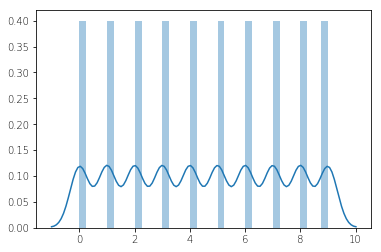

In [9]:
sns.distplot(data.train_labels)

We find an equal distribution for all classes i.e. 6000 for all 10 fashion classes

Let's look at the images...

In [10]:
def plot_images(imgs, figsize=(12,6), titles=None, maintitle=None):
    fig = plt.figure(figsize=figsize)
    imgs = np.array(imgs)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=16)
    imgs_len = len(imgs)
    for idx in range(imgs_len):
        subplt = fig.add_subplot(1, imgs_len, idx+1)
        subplt.axis('Off')
        if titles is not None:
            subplt.set_title(titles[idx], fontsize=16)
        plt.imshow(imgs[idx], cmap='gray')

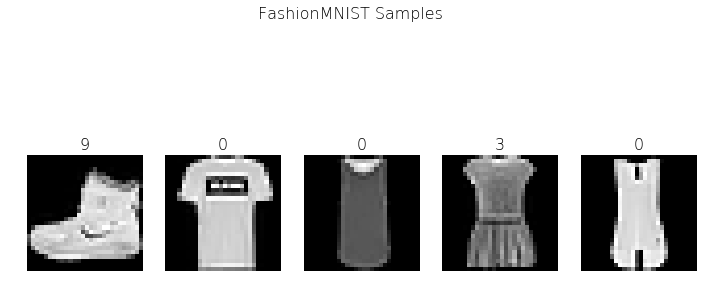

In [11]:
plot_images(data.train_data[:5],
            titles=data.train_labels[:5],
            maintitle='FashionMNIST Samples')

In [12]:
data.train_data.shape

torch.Size([60000, 28, 28])

Hence, we have 60,000 images of dimensions 28 by 28

## Data Preprocessing

Here we split the dataset into sample_train, sample_valid, train and valid sets.

Sample dataset is for testing on local machine before training on the cloud. It is set by the global config SAMPLE.

In [14]:
sample_train = data.train_data[:1000]
sample_train_labels = data.train_labels[:1000]
sample_valid = data.train_data[1000:1100]
sample_valid_labels = data.train_labels[1000:1100]

In [15]:
train = data.train_data[:50000]
train_labels = data.train_labels[:50000]
valid = data.train_data[50000:60000]
valid_labels = data.train_labels[50000:60000]

Create data directory structure

In [81]:
os.mkdir(DATAPATH+'train')
os.mkdir(DATAPATH+'valid')

In [82]:
# a sample of the dataset
os.mkdir(DATAPATH+'sample/train')
os.mkdir(DATAPATH+'sample/valid')

Populate data directories

In [83]:
def imwrite_dir(images, labels, path):
    # make directory structure for labels or classes
    for label in np.unique(labels):
        os.mkdir(path+str(label))
    # put the images in the proper label directories
    for i in range(images.shape[0]):
        image = images[i]
        filepath = path+str(labels[i])+'/'+str(i)+'.jpg'
        torchvision.utils.save_image(image,
                                     filepath)

In [84]:
imwrite_dir(sample_train, sample_train_labels, DATAPATH+'sample/train/')
imwrite_dir(sample_valid, sample_valid_labels, DATAPATH+'sample/valid/')

In [85]:
imwrite_dir(train, train_labels, DATAPATH+'train/')
imwrite_dir(valid, valid_labels, DATAPATH+'valid/')

## Training Model [resnet34]

In [90]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH,tfms=tfms_from_model(arch, size))

In [91]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

  0%|          | 0/2 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/mnt/Work/ML-AI/diff_code/fastai/fastai/dataloader.py", line 75, in __iter__
    for batch in e.map(self.get_batch, iter(self.batch_sampler)):
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/concurrent/futures/_base.py", line 586, in result_iterator
    yield fs.pop().result()
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/concurrent/futures/_base.py", line 427, in result
    self._condition.wait(timeout)
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/aman/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-91-821d57927aad>", line 1, in <module>
    learn = ConvLearner.pretrained(arch, data, precompute=

TypeError: must be str, not list

In [ ]:
q